## Prophet Forecasting on Cleaned General Dam Dataset

16:10:47 - cmdstanpy - INFO - Chain [1] start processing
16:10:48 - cmdstanpy - INFO - Chain [1] done processing


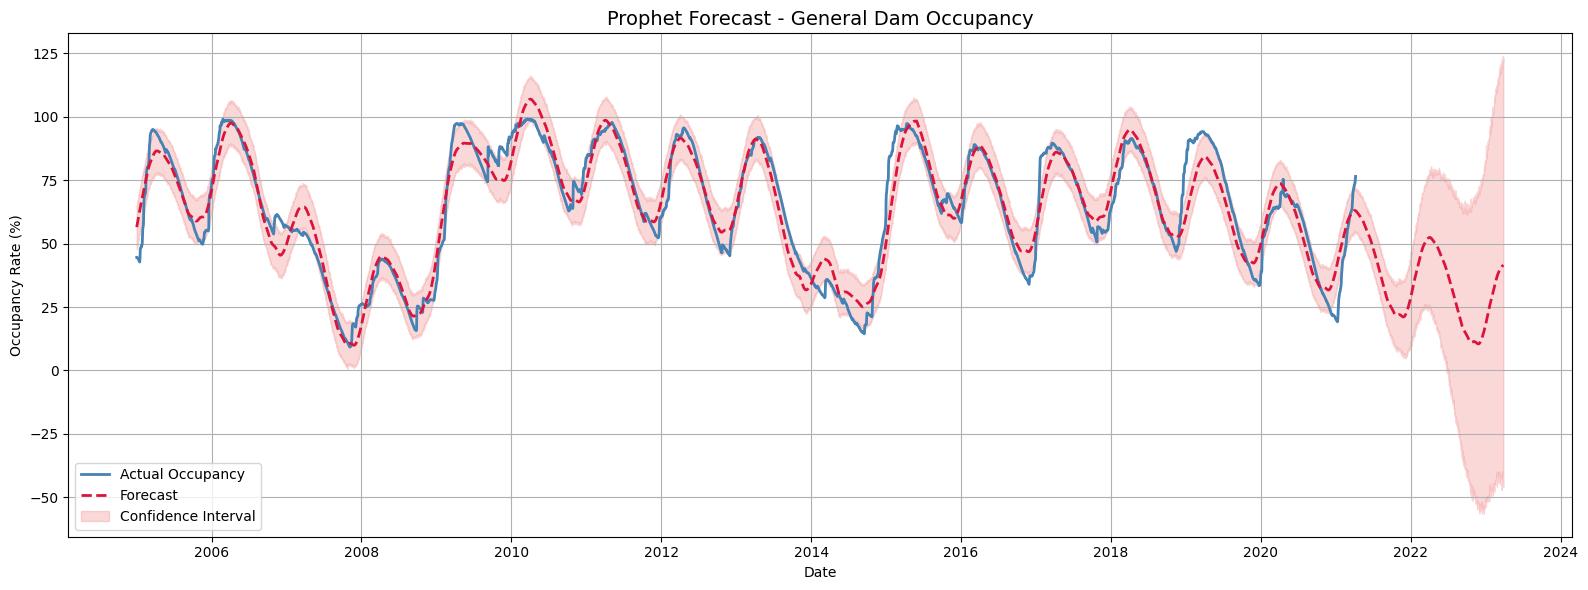

Prophet MAE (Test Set): 16.55
Prophet RMSE (Test Set): 18.06


In [1]:
# Importing necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.dates as mdates

# Loading cleaned general dataset
df_general = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])

# Preparing data for Prophet
df_prophet = df_general.rename(columns={'DATE': 'ds', 'GENERAL_DAM_OCCUPANCY_RATE': 'y'})
df_prophet = df_prophet[['ds', 'y']]

# Defining and fitting the model
model = Prophet()

model.fit(df_prophet)

# Creating future dataframe 
future = model.make_future_dataframe(periods=720)
forecast = model.predict(future)

# Plotting the forecast
plt.figure(figsize=(16, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], color='steelblue', linewidth=2, label='Actual Occupancy')
plt.plot(forecast['ds'], forecast['yhat'], color='crimson', linestyle='--', linewidth=2, label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='lightcoral', alpha=0.3, label='Confidence Interval')

plt.title("Prophet Forecast - General Dam Occupancy", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Evaluating performance on test set (last 180 days)
actual = df_prophet.set_index('ds').y[-180:].values
predicted = forecast.set_index('ds').yhat[-180:].values

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"Prophet MAE (Test Set): {mae:.2f}")
print(f"Prophet RMSE (Test Set): {rmse:.2f}")

import pickle
with open("../models/prophet_only_occupancy_general.pkl", "wb") as f:
    pickle.dump(model, f)


## SARIMA Forecasting on Cleaned General Dam Dataset


Selected SARIMA Order: (2, 1, 2), Seasonal Order: (0, 0, 0, 0)


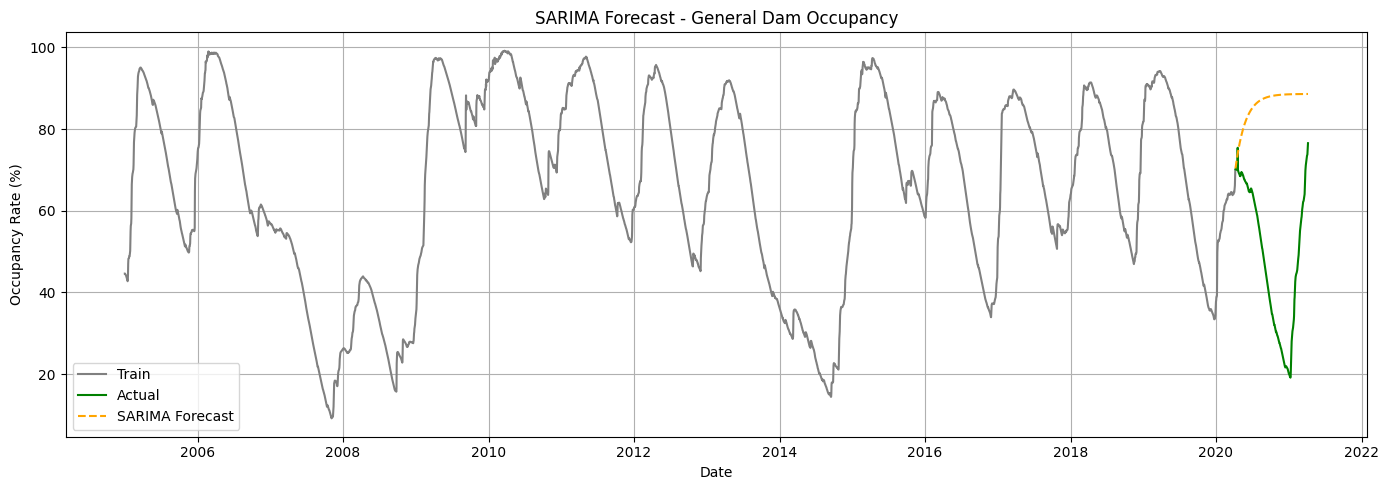

SARIMA MAE (Test Set): 37.58
SARIMA RMSE (Test Set): 42.60


In [16]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Loading cleaned general dataset
df_general = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])
df_general.set_index('DATE', inplace=True)

# Selecting target variable
series = df_general['GENERAL_DAM_OCCUPANCY_RATE']

# Splitting into train and test
train_size = int(len(series) -365)
train, test = series[:train_size], series[train_size:]

# Automatically selecting SARIMA parameters
stepwise_model = auto_arima(train, seasonal=False, m=365,
                            suppress_warnings=True, stepwise=True,
                            error_action="ignore", trace=False)

order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print(f"Selected SARIMA Order: {order}, Seasonal Order: {seasonal_order}")

# Fitting SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
sarima_result = model.fit(disp=False)

# Forecasting
forecast = sarima_result.forecast(steps=len(test))

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Train', color='gray')
plt.plot(test.index, test, label='Actual', color='green')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='orange', linestyle='--')
plt.title("SARIMA Forecast - General Dam Occupancy")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluating performance
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"SARIMA MAE (Test Set): {mae:.2f}")
print(f"SARIMA RMSE (Test Set): {rmse:.2f}")

import pickle
with open("../models/prophet_only_occupancy.pkl", "wb") as f:
    pickle.dump(model, f)


## Univariate LSTM Forecasting on Cleaned General Dam Dataset

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0227 - val_loss: 0.0010
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0046 - val_loss: 5.8062e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0043 - val_loss: 5.1380e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0041 - val_loss: 5.4879e-04
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0037 - val_loss: 3.1506e-04
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0034 - val_loss: 4.6900e-04
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032 - val_loss: 9.5860e-04
Epoch 9/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0030 - val_loss: 2.8995e-04
Epoch 10/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0028 - val_loss: 5.7468e-04
Epoch 11/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0024 - val_loss: 2.3941e-04
Epoch

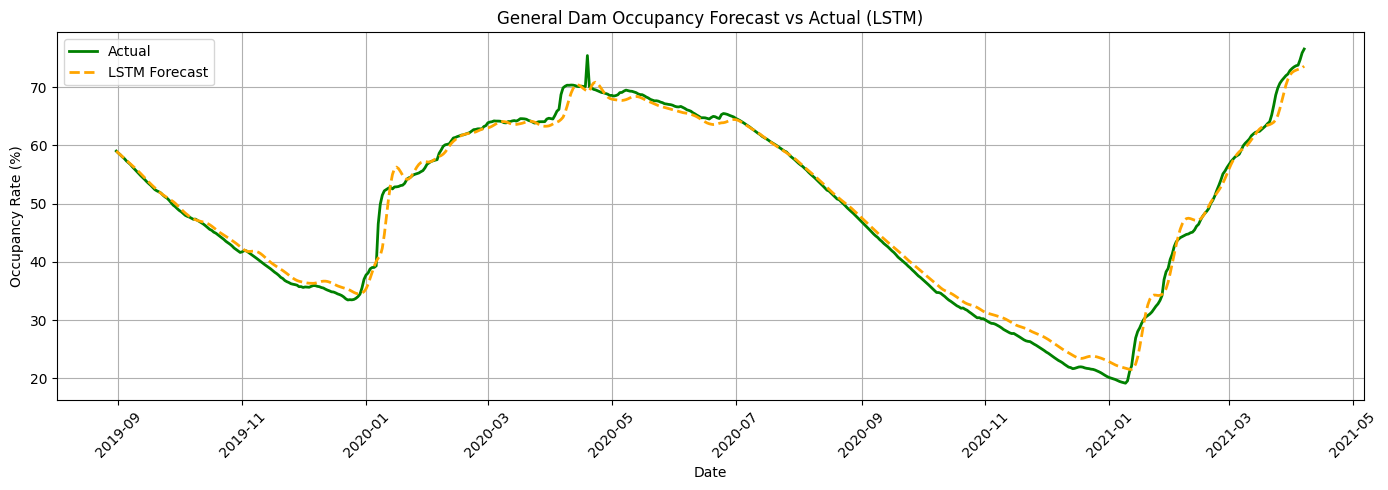

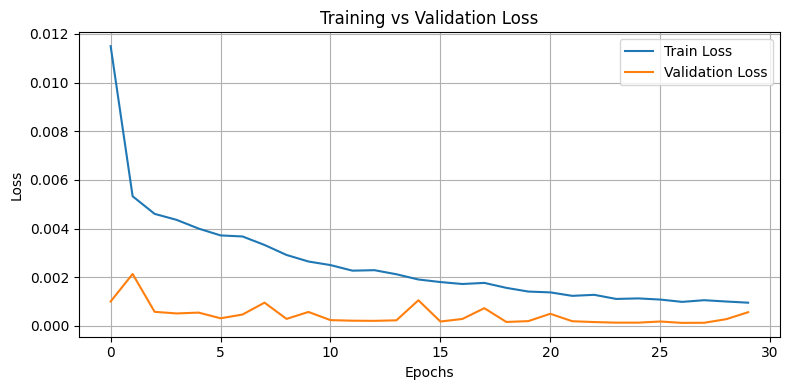

In [14]:
# Importing necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Copying original data
df_lstm = df_general.copy()

# Creating lag and rolling features
df_lstm['GENERAL_DAM_OCCUPANCY_RATE_lag1'] = df_lstm['GENERAL_DAM_OCCUPANCY_RATE'].shift(1)
df_lstm['GENERAL_DAM_OCCUPANCY_RATE_rolling7'] = df_lstm['GENERAL_DAM_OCCUPANCY_RATE'].rolling(window=7).mean()
df_lstm['GENERAL_DAM_OCCUPANCY_RATE_rolling30'] = df_lstm['GENERAL_DAM_OCCUPANCY_RATE'].rolling(window=30).mean()

# Dropping NaNs
df_lstm = df_lstm.dropna().reset_index(drop=True)

# Selecting features and target
feature_cols = ['GENERAL_DAM_OCCUPANCY_RATE_lag1', 'GENERAL_DAM_OCCUPANCY_RATE_rolling7', 'GENERAL_DAM_OCCUPANCY_RATE_rolling30']
target_col = 'GENERAL_DAM_OCCUPANCY_RATE'
dates = df_lstm['DATE'][60:].reset_index(drop=True)  # Aligning with sequences

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_lstm[feature_cols])
y_scaled = scaler_y.fit_transform(df_lstm[[target_col]])

# Creating sequences
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Splitting into train/val/test
train_size = int(len(X_seq) * 0.8)
val_size = int(len(X_seq) * 0.1)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
dates_test = dates[train_size + val_size:]

# Building the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

# Making predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Calculating performance
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM MAE (Test Set): {mae:.2f}")
print(f"LSTM RMSE (Test Set): {rmse:.2f}")

# Plotting forecast vs actual
plt.figure(figsize=(14, 5))
plt.plot(dates_test, y_test_inv, label="Actual", color='green', linewidth=2)
plt.plot(dates_test, y_pred_inv, label="LSTM Forecast", color='orange', linestyle='--', linewidth=2)
plt.title("General Dam Occupancy Forecast vs Actual (LSTM)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting overfit control (loss graph)
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.save("../models/lstm_univariate_only_occupancy_general.h5")


## Forecasting Next 60 Days Using Recursive LSTM Predictions (General Dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

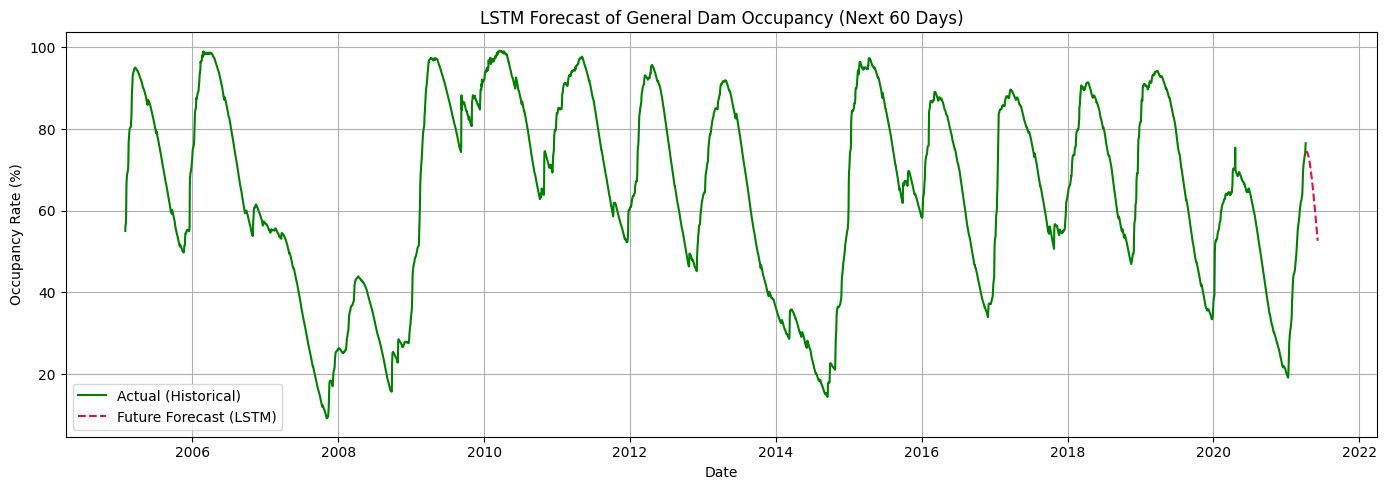

In [9]:
# Forecasting future values using last available sequence
future_steps = 60  # Number of days to forecast
last_sequence = X_seq[-1]  # Taking the last 60-day sequence from original data
forecast_sequence = last_sequence.copy()

future_predictions = []

# Recursive prediction loop
for _ in range(future_steps):
    input_seq = np.expand_dims(forecast_sequence, axis=0)  # (1, 60, 3)
    next_pred = model.predict(input_seq)[0]
    future_predictions.append(next_pred)

    # Creating the next timestep input
    next_input = forecast_sequence[-1].copy()
    next_input[0] = next_pred  # lag1 = predicted value
    # Updating rolling features by simple shifting (can be refined further)
    next_input[1] = (forecast_sequence[-7:, 0].mean() + next_pred[0]) / 2  # new rolling7
    next_input[2] = (forecast_sequence[-30:, 0].mean() + next_pred[0]) / 2  # new rolling30

    forecast_sequence = np.vstack([forecast_sequence[1:], next_input])

# Inverse scaling
future_predictions_inv = scaler_y.inverse_transform(np.array(future_predictions))

# Generating future dates
last_date = df_lstm['DATE'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Plotting actual + future forecast
plt.figure(figsize=(14, 5))
plt.plot(df_lstm['DATE'], df_lstm['GENERAL_DAM_OCCUPANCY_RATE'], label="Actual (Historical)", color='green')
plt.plot(future_dates, future_predictions_inv, label="Future Forecast (LSTM)", color='crimson', linestyle='--')
plt.title("LSTM Forecast of General Dam Occupancy (Next 60 Days)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Multivariate LSTM Forecasting on Cleaned General Dam Dataset


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Multivariate LSTM MAE (Test Set): 0.56
Multivariate LSTM RMSE (Test Set): 0.96


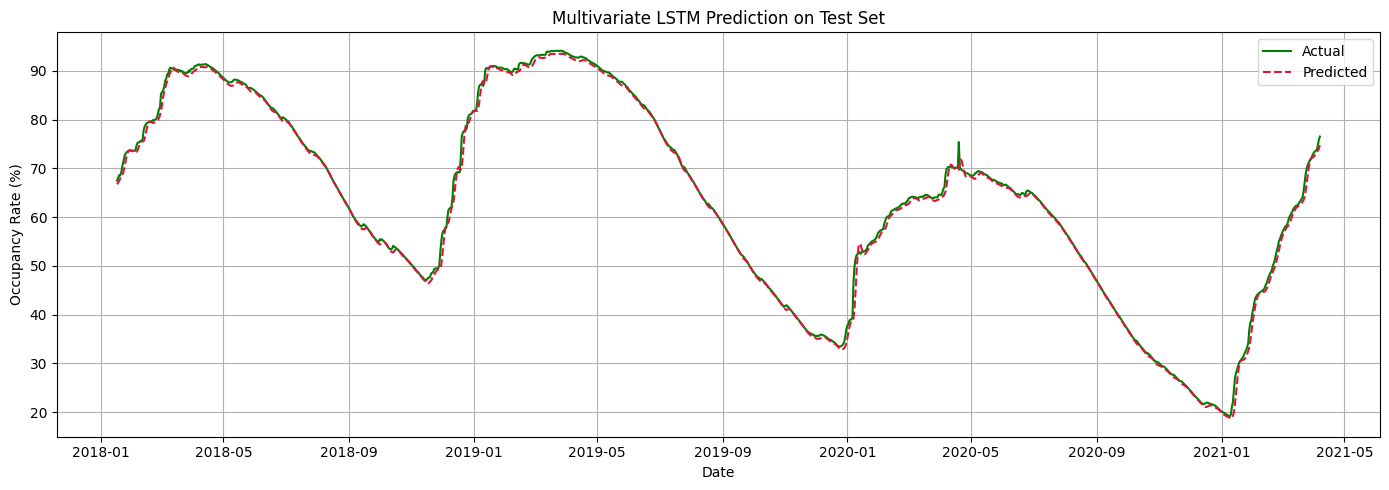

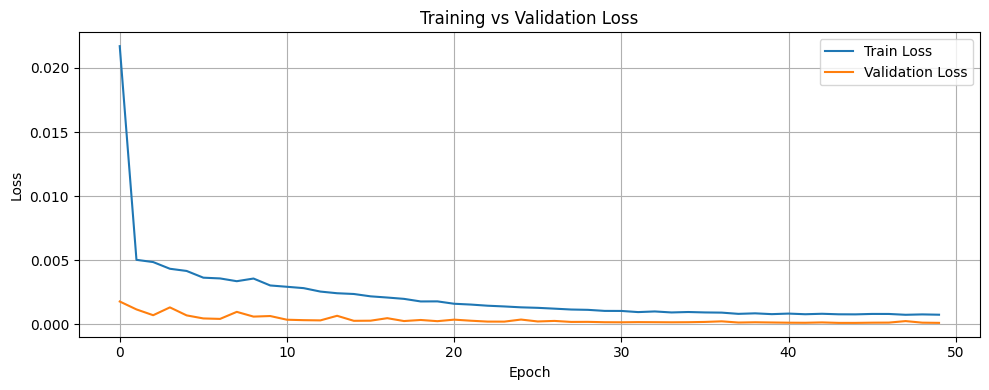

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

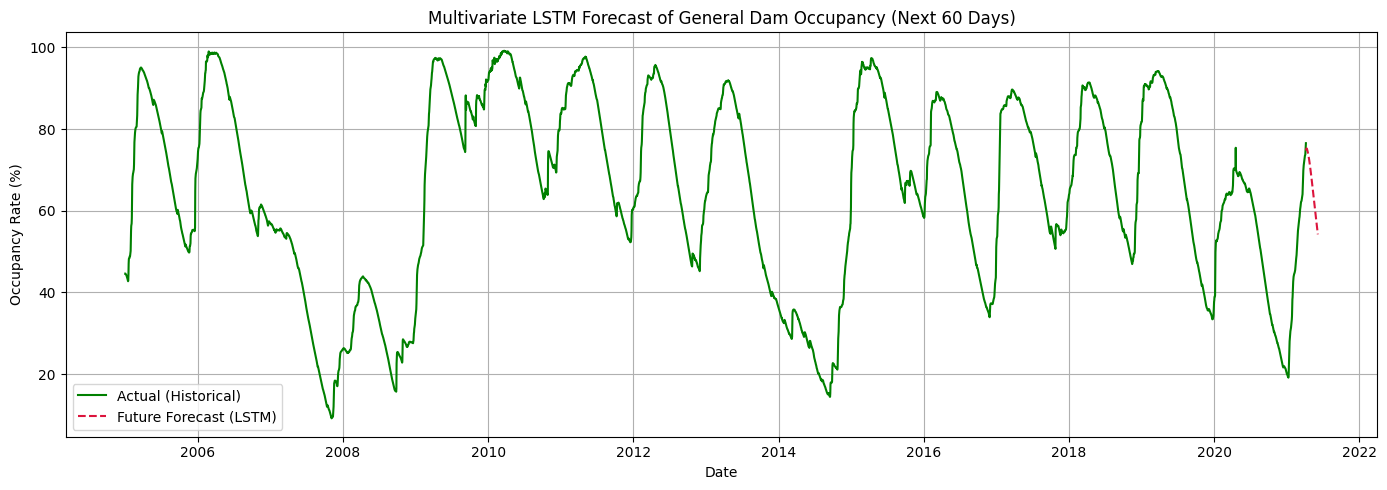

In [15]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loading cleaned general dam dataset
df_multi = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_multi['DATE'] = pd.to_datetime(df_multi['DATE'])

# Selecting features and target (multivariate inputs)
features = ['GENERAL_DAM_RESERVED_WATER']
target = ['GENERAL_DAM_OCCUPANCY_RATE']
df_model = df_multi[features + target].copy()

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_model[features])
y_scaled = scaler_y.fit_transform(df_model[target])

# Creating input sequences
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)
date_seq = df_multi['DATE'][60:].reset_index(drop=True)

# Train/val/test split
train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.1)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
date_test = date_seq[train_size + val_size:]

# Building the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# Test set prediction
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluation metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Multivariate LSTM MAE (Test Set): {round(mae, 2)}")
print(f"Multivariate LSTM RMSE (Test Set): {round(rmse, 2)}")

# Plotting predictions vs actual
plt.figure(figsize=(14, 5))
plt.plot(date_test, y_test_inv, label="Actual", color='green')
plt.plot(date_test, y_pred_inv, label="Predicted", color='crimson', linestyle='--')
plt.title("Multivariate LSTM Prediction on Test Set")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting loss curve
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# Forecasting next 60 days
# ==============================

future_steps = 60
forecast_input = X_seq[-1]
future_forecast = []

for _ in range(future_steps):
    input_seq = np.expand_dims(forecast_input, axis=0)
    next_pred = model.predict(input_seq)[0]
    future_forecast.append(next_pred)

    next_input = forecast_input[-1].copy()
    next_input[0] = next_pred[0]
    forecast_input = np.vstack([forecast_input[1:], next_input])

# Inverse scaling
future_forecast_inv = scaler_y.inverse_transform(np.array(future_forecast))
last_date = df_multi['DATE'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)

# Plotting actual + future forecast
plt.figure(figsize=(14, 5))
plt.plot(df_multi['DATE'], df_multi['GENERAL_DAM_OCCUPANCY_RATE'], label="Actual (Historical)", color='green')
plt.plot(future_dates, future_forecast_inv, label="Future Forecast (LSTM)", color='crimson', linestyle='--')
plt.title("Multivariate LSTM Forecast of General Dam Occupancy (Next 60 Days)")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

model.save("../models/lstm_multivariate_only_occupancy_general.h5")



## Prophet Forecasting for Each Dam (Occupancy Only)



Training Prophet model for: Omerli


16:09:40 - cmdstanpy - INFO - Chain [1] start processing
16:09:43 - cmdstanpy - INFO - Chain [1] done processing


Omerli - Prophet MAE: 0.18 | RMSE: 0.18


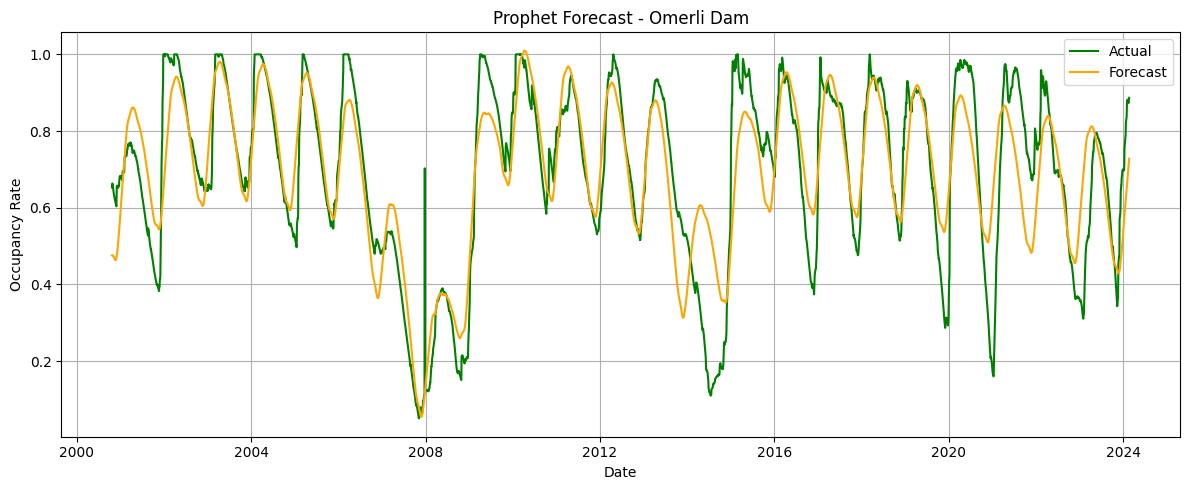

Model saved as: ../models/multivariate_models_only_occupancy/prophet_omerli.pkl

Training Prophet model for: Darlik


16:09:46 - cmdstanpy - INFO - Chain [1] start processing
16:09:48 - cmdstanpy - INFO - Chain [1] done processing


Darlik - Prophet MAE: 0.26 | RMSE: 0.26


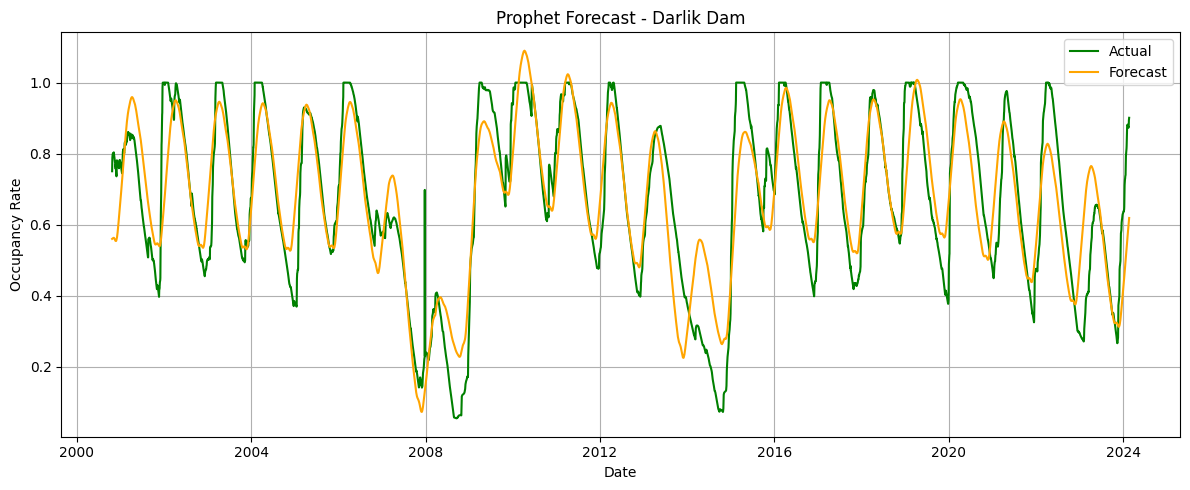

Model saved as: ../models/multivariate_models_only_occupancy/prophet_darlik.pkl

Training Prophet model for: Elmali


16:09:51 - cmdstanpy - INFO - Chain [1] start processing
16:09:55 - cmdstanpy - INFO - Chain [1] done processing


Elmali - Prophet MAE: 0.45 | RMSE: 0.45


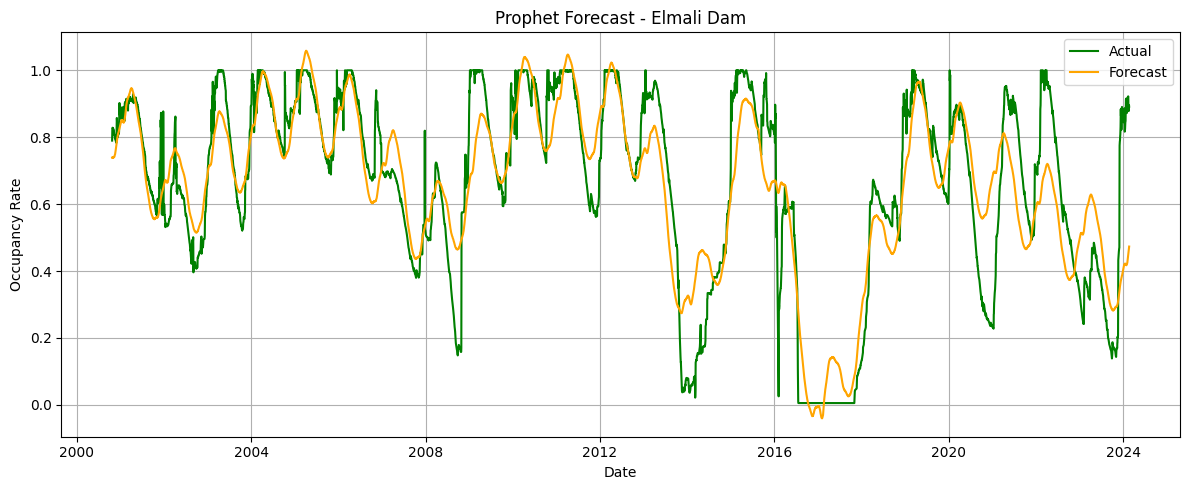

Model saved as: ../models/multivariate_models_only_occupancy/prophet_elmali.pkl

Training Prophet model for: Terkos


16:09:58 - cmdstanpy - INFO - Chain [1] start processing
16:10:00 - cmdstanpy - INFO - Chain [1] done processing


Terkos - Prophet MAE: 0.2 | RMSE: 0.21


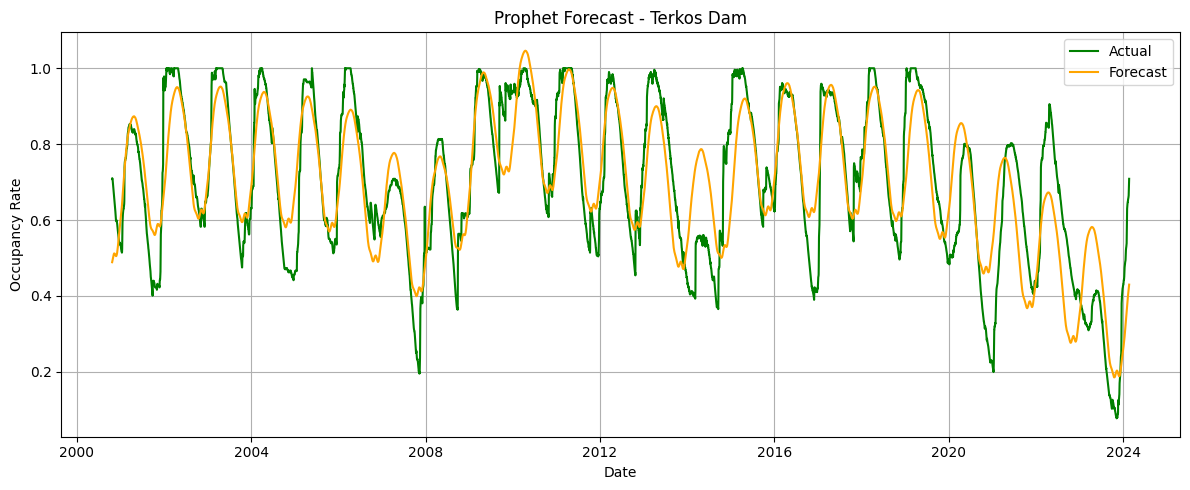

Model saved as: ../models/multivariate_models_only_occupancy/prophet_terkos.pkl

Training Prophet model for: Alibey


16:10:03 - cmdstanpy - INFO - Chain [1] start processing
16:10:05 - cmdstanpy - INFO - Chain [1] done processing


Alibey - Prophet MAE: 0.44 | RMSE: 0.44


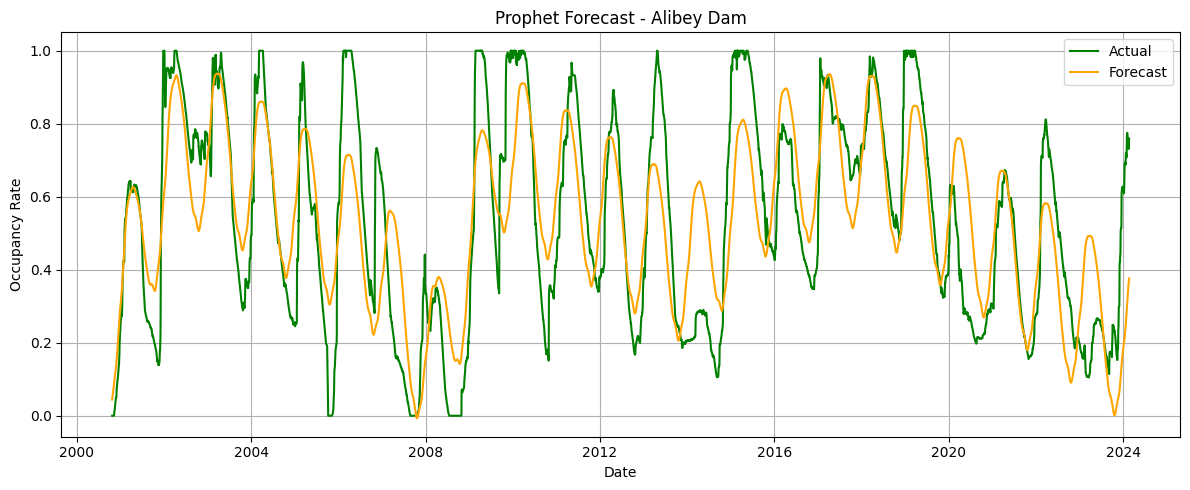

Model saved as: ../models/multivariate_models_only_occupancy/prophet_alibey.pkl

Training Prophet model for: Buyukcekmece


16:10:07 - cmdstanpy - INFO - Chain [1] start processing
16:10:10 - cmdstanpy - INFO - Chain [1] done processing


Buyukcekmece - Prophet MAE: 0.24 | RMSE: 0.24


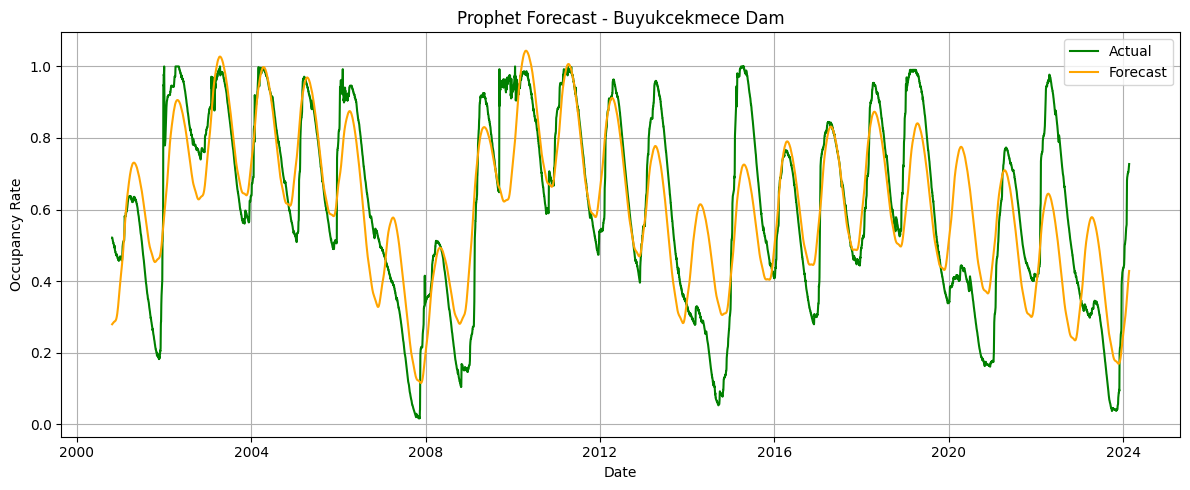

Model saved as: ../models/multivariate_models_only_occupancy/prophet_buyukcekmece.pkl

Training Prophet model for: Sazlidere


16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:16 - cmdstanpy - INFO - Chain [1] done processing


Sazlidere - Prophet MAE: 0.14 | RMSE: 0.14


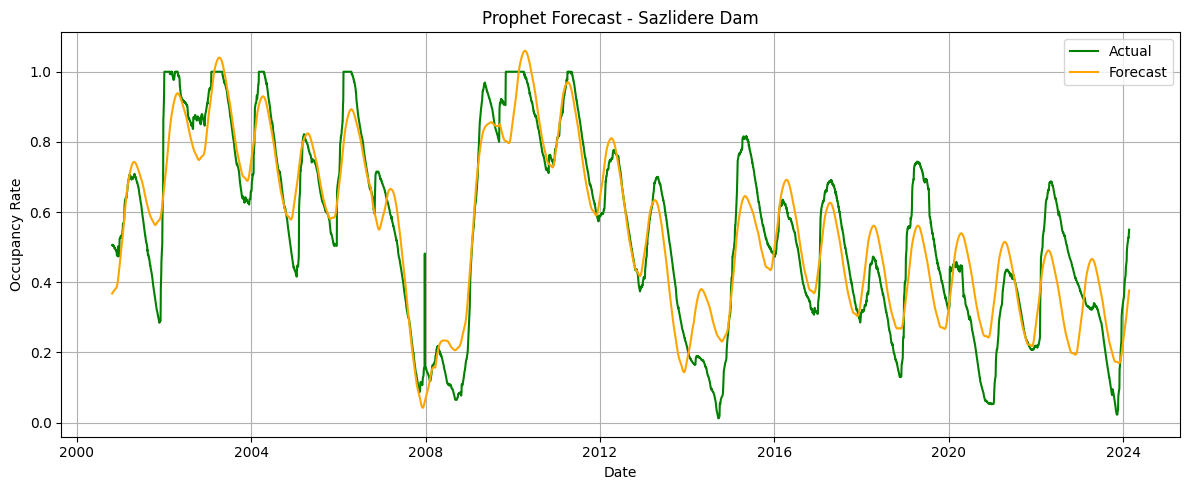

Model saved as: ../models/multivariate_models_only_occupancy/prophet_sazlidere.pkl

Training Prophet model for: Kazandere


16:10:19 - cmdstanpy - INFO - Chain [1] start processing
16:10:21 - cmdstanpy - INFO - Chain [1] done processing


Kazandere - Prophet MAE: 0.36 | RMSE: 0.36


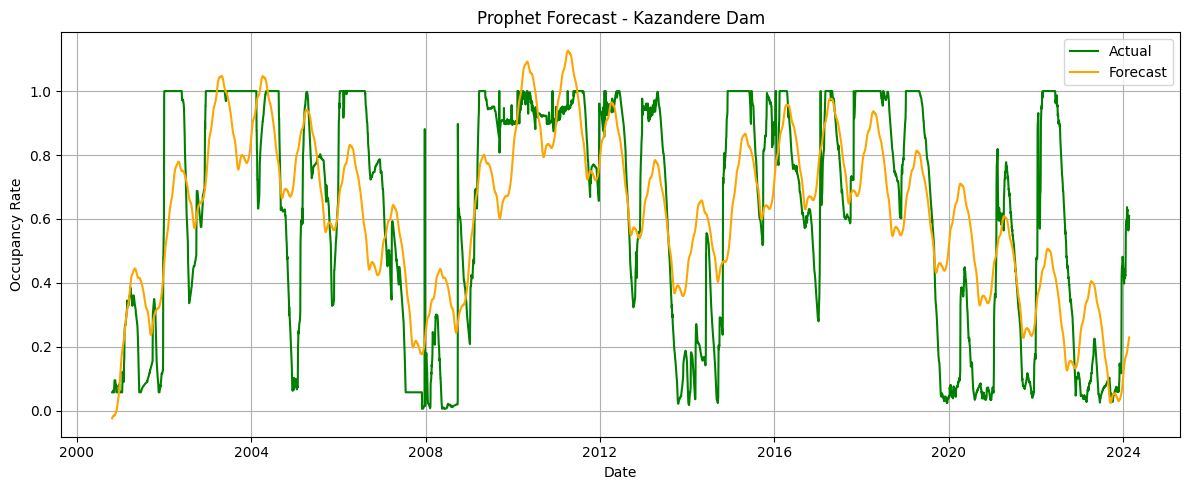

Model saved as: ../models/multivariate_models_only_occupancy/prophet_kazandere.pkl

Training Prophet model for: Pabucdere


16:10:24 - cmdstanpy - INFO - Chain [1] start processing
16:10:25 - cmdstanpy - INFO - Chain [1] done processing


Pabucdere - Prophet MAE: 0.26 | RMSE: 0.27


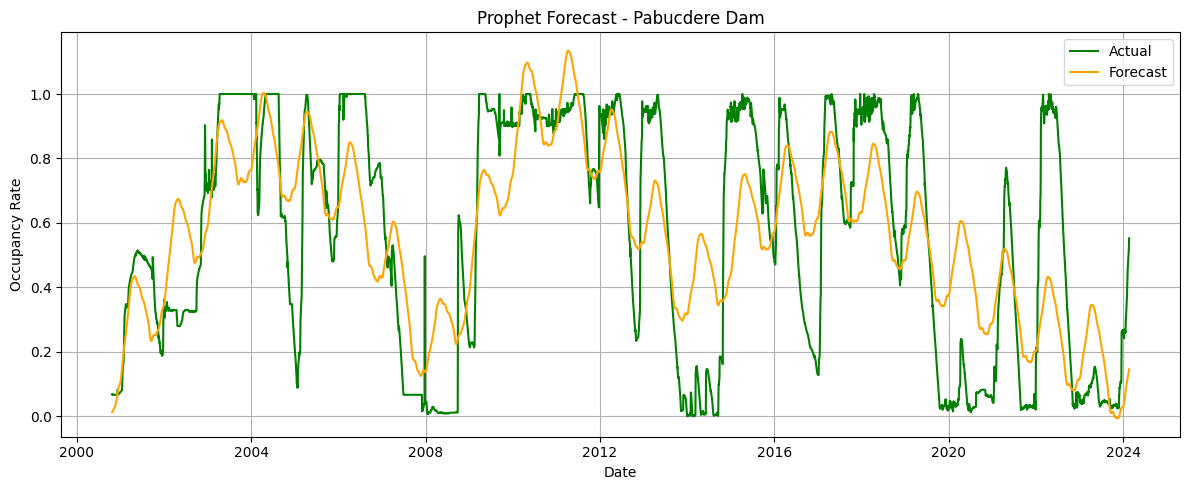

Model saved as: ../models/multivariate_models_only_occupancy/prophet_pabucdere.pkl

Training Prophet model for: Istrancalar


16:10:28 - cmdstanpy - INFO - Chain [1] start processing
16:10:30 - cmdstanpy - INFO - Chain [1] done processing


Istrancalar - Prophet MAE: 0.13 | RMSE: 0.18


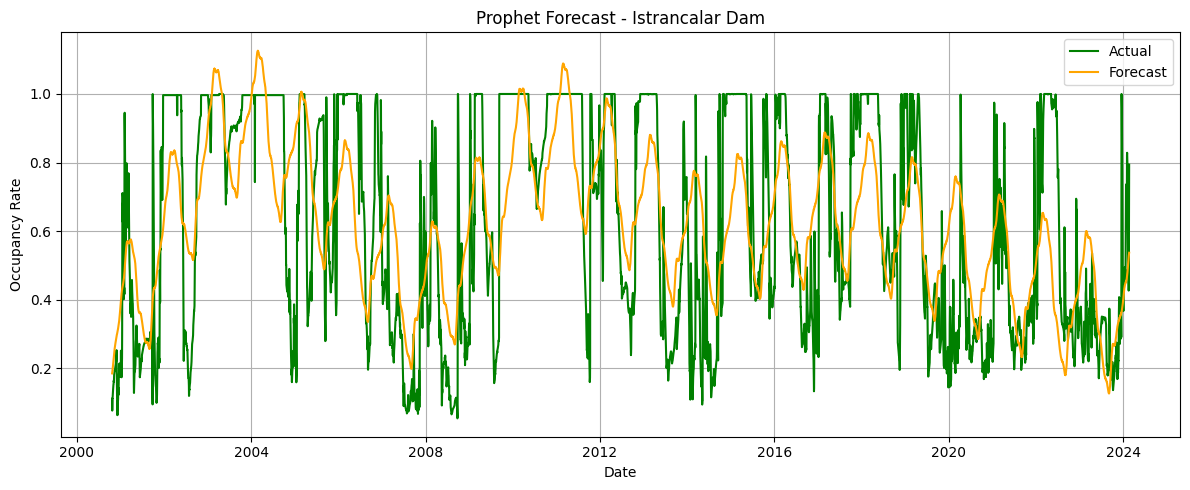

Model saved as: ../models/multivariate_models_only_occupancy/prophet_istrancalar.pkl


In [1]:
# Importing necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Creating output directory for models if not exists
os.makedirs("../models/prophet_dam_specific", exist_ok=True)

# Iterating over each dam column
dam_columns = df_dams.columns.drop('Tarih')

for dam in dam_columns:
    print(f"\nTraining Prophet model for: {dam}")

    # Preparing dataset for Prophet
    df_prophet = df_dams[['Tarih', dam]].rename(columns={'Tarih': 'ds', dam: 'y'})

    # Splitting into train and test (last 60 days as test)
    df_train = df_prophet[:-60]
    df_test = df_prophet[-60:]

    # Initializing and fitting the model
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(df_train)

    # Forecasting future including test period
    future = model.make_future_dataframe(periods=60)
    forecast = model.predict(future)

    # Extracting prediction corresponding to test dates
    forecast_test = forecast.set_index('ds').loc[df_test['ds']]
    predicted = forecast_test['yhat'].values
    actual = df_test['y'].values

    # Calculating metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"{dam} - Prophet MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(df_prophet['ds'], df_prophet['y'], label="Actual", color="green")
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color="orange")
    plt.title(f"Prophet Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    import joblib

    # Saving the trained Prophet model
    joblib.dump(model, f"../models/multivariate_models_only_occupancy/prophet_{dam.lower()}.pkl")
    print(f"Model saved as: ../models/multivariate_models_only_occupancy/prophet_{dam.lower()}.pkl")






## SARIMA Forecasting on Dam-Specific Datasets


Training SARIMA model for: Omerli
Selected SARIMA Order for Omerli: (2, 1, 5)
Omerli - SARIMA MAE: 0.05 | RMSE: 0.06


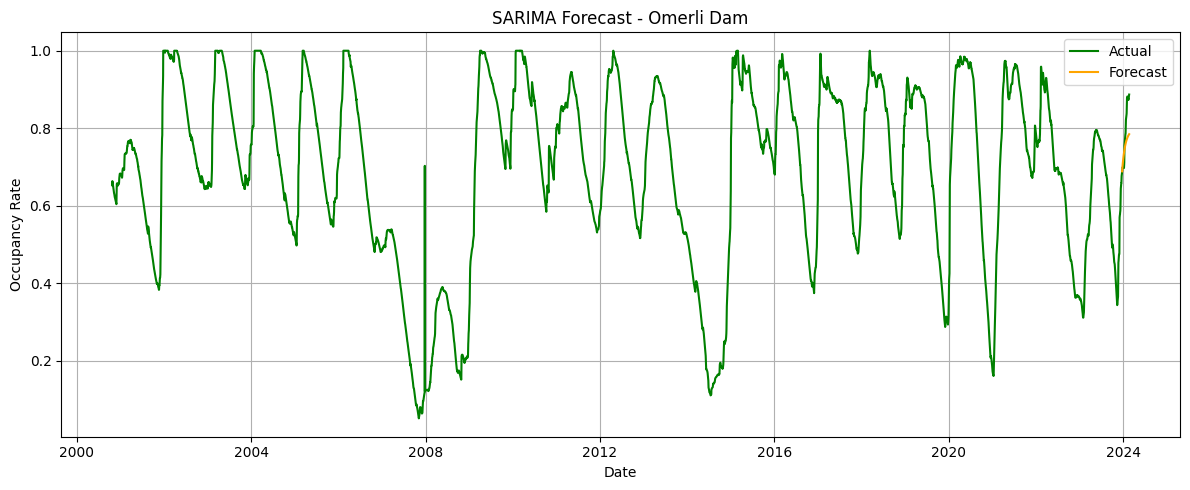

Model saved: ../models/multivariate_models_only_occupancy/sarima_omerli.pkl

Training SARIMA model for: Darlik
Selected SARIMA Order for Darlik: (2, 1, 5)
Darlik - SARIMA MAE: 0.05 | RMSE: 0.07


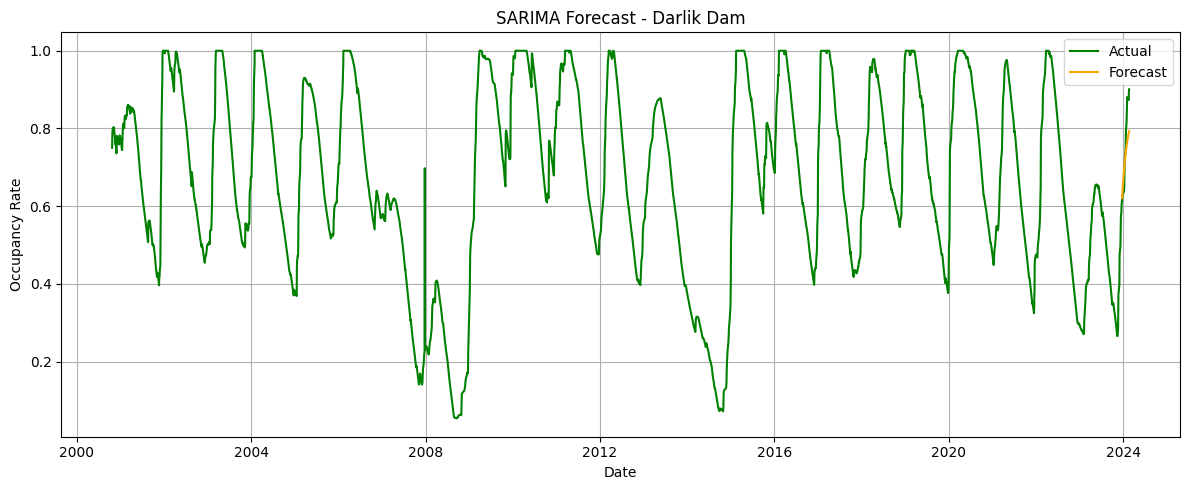

Model saved: ../models/multivariate_models_only_occupancy/sarima_darlik.pkl

Training SARIMA model for: Elmali
Selected SARIMA Order for Elmali: (2, 1, 2)


KeyboardInterrupt: 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import warnings
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Output directory
os.makedirs("../models/multivariate_models_only_occupancy", exist_ok=True)

# List of dam columns (excluding date)
dam_columns = df_dams.columns.drop('Tarih')

for dam in dam_columns:
    print(f"\nTraining SARIMA model for: {dam}")
    
    # Preparing time series
    series = df_dams.set_index('Tarih')[dam]

    # Splitting (last 60 days as test)
    train = series[:-60]
    test = series[-60:]

    # Finding best SARIMA parameters
    model_auto = auto_arima(train, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
    order = model_auto.order
    print(f"Selected SARIMA Order for {dam}: {order}")

    # Fitting the model
    model = sm.tsa.ARIMA(train, order=order)
    results = model.fit()

    # Forecasting
    forecast = results.forecast(steps=60)

    # Evaluation
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    print(f"{dam} - SARIMA MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series.values, label="Actual", color="green")
    plt.plot(test.index, forecast, label="Forecast", color="orange")
    plt.title(f"SARIMA Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Saving the model
    model_path = f"../models/multivariate_models_only_occupancy/sarima_{dam.lower()}.pkl"
    joblib.dump(results, model_path)
    print(f"Model saved: {model_path}")


## Univariate LSTM for Dam-Specific Forecasting


Training Univariate LSTM for: Omerli
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Omerli - LSTM MAE: 0.0 | RMSE: 0.01


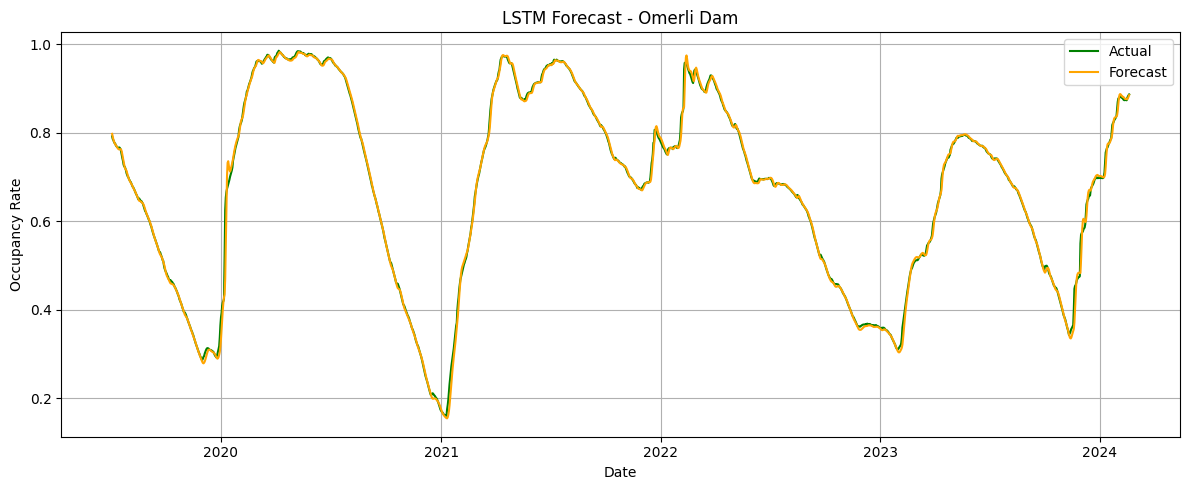

Model and scaler saved for Omerli

Training Univariate LSTM for: Darlik
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Darlik - LSTM MAE: 0.01 | RMSE: 0.01


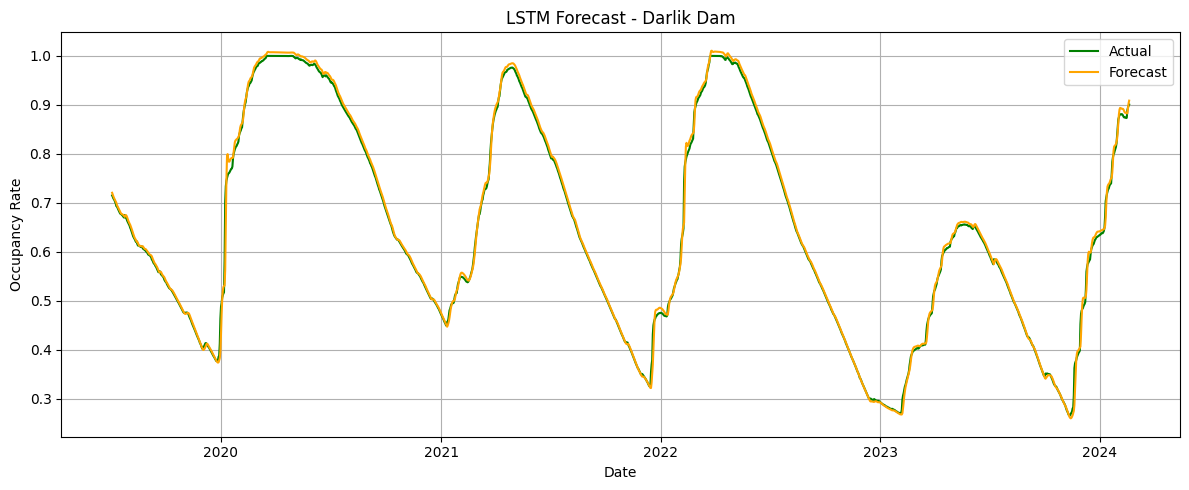

Model and scaler saved for Darlik

Training Univariate LSTM for: Elmali
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Elmali - LSTM MAE: 0.01 | RMSE: 0.01


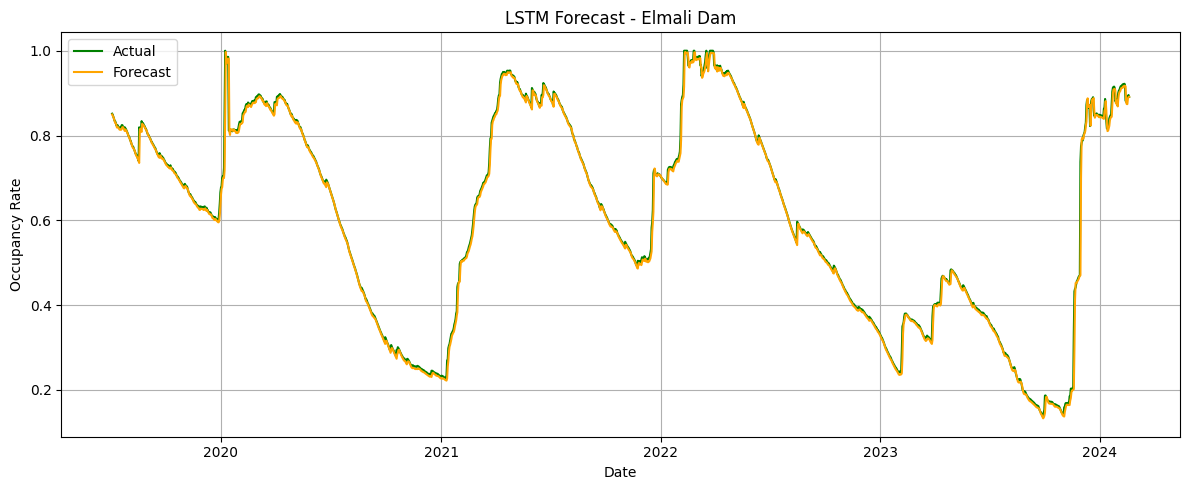

Model and scaler saved for Elmali

Training Univariate LSTM for: Terkos


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import joblib

# Creating output directories
os.makedirs("../models/multivariate_models_only_occupancy/lstm_univariate", exist_ok=True)
os.makedirs("../models/multivariate_models_only_occupancy/lstm_univariate/scalers", exist_ok=True)

# Loading cleaned dam-specific dataset
df = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df['Tarih'] = pd.to_datetime(df['Tarih'])

dam_columns = df.columns.drop('Tarih')

# Feature engineering function
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

for dam in dam_columns:
    print(f"\nTraining Univariate LSTM for: {dam}")

    series = df[[dam]].values

    # Normalizing
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series)

    # Creating sequences
    time_steps = 60
    X, y = create_sequences(series_scaled, time_steps)

    # Train/val/test split
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.1)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Model building
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

    # Evaluation
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"{dam} - LSTM MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plot
    test_dates = df['Tarih'][len(df) - len(y_test):].reset_index(drop=True)
    plt.figure(figsize=(12, 5))
    plt.plot(test_dates, y_test_inv, label="Actual", color="green")
    plt.plot(test_dates, y_pred_inv, label="Forecast", color="orange")
    plt.title(f"LSTM Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Saving model and scaler
    model.save(f"../models/multivariate_models_only_occupancy/lstm_univariate/lstm_{dam.lower()}.h5")
    joblib.dump(scaler, f"../models/multivariate_models_only_occupancy/lstm_univariate/scalers/scaler_{dam.lower()}.pkl")
    print(f"Model and scaler saved for {dam}")


## Multivariate LSTM for Dam-Specific Forecasting 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import joblib

# Creating output directories
os.makedirs("../models/multivariate_models_only_occupancy/lstm_multivariate", exist_ok=True)
os.makedirs("../models/multivariate_models_only_occupancy/lstm_multivariate/scalers", exist_ok=True)

# Loading cleaned dam-specific dataset
df = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df['Tarih'] = pd.to_datetime(df['Tarih'])

dam_columns = df.columns.drop('Tarih')

# Scaling all features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[dam_columns])
joblib.dump(scaler_X, "../models/multivariate_models_only_occupancy/lstm_multivariate/scalers/scaler_X.pkl")

# Saving dates
dates = df['Tarih'].reset_index(drop=True)

# Sequence creation function
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

# Looping through each dam
for dam in dam_columns:
    print(f"\nTraining Multivariate LSTM for: {dam}")

    # Output (y) column
    y = df[[dam]]
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)
    joblib.dump(scaler_y, f"../models/multivariate_models_only_occupancy/lstm_multivariate/scalers/scaler_y_{dam.lower()}.pkl")

    # Create sequences
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=60)
    date_seq = dates[60:].reset_index(drop=True)

    # Train/val/test split
    train_size = int(len(X_seq) * 0.7)
    val_size = int(len(X_seq) * 0.1)

    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
    X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
    date_test = date_seq[train_size + val_size:]

    # Building the model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

    # Predicting
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # Evaluation
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"{dam} - Multivariate LSTM MAE: {round(mae, 2)} | RMSE: {round(rmse, 2)}")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(date_test, y_test_inv, label="Actual", color="green")
    plt.plot(date_test, y_pred_inv, label="Forecast", color="orange")
    plt.title(f"Multivariate LSTM Forecast - {dam} Dam")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save model and scaler
    model.save(f"../models/multivariate_models_only_occupancy/lstm_multivariate/lstm_multi_{dam.lower()}.h5")
    print(f"Model and scaler saved for {dam}")
